# CS 180 Project: mAIyu

<br>

mAIyu is specifically created and trained to predict the most preferred type of contraceptive of individuals from varying socioeconomic status based on a user’s background. The results coming from mAIyu may be aggregated and analyzed, which can then be used in gauging the knowledge of users about the different types of contraceptives. Furthermore, the information that would be gathered from the results could be used  to provide the contraceptive market a reliable basis on which contraceptive they should focus on producing and which contraceptive they need to promote better to the masses, both of which could help curb the ever-rising number of adolescent pregnancies in the Philippines.

<br>

---
! Run the cell below to load the libraries needed

In [14]:
import ipynb.fs.defs.Utils as utils
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

#--------------------------------------------------------------------------------------------
# Settings
#--------------------------------------------------------------------------------------------
sns.set(font_scale=1.5)
sns.set_style("dark")

## A. Dataset

<br>

The dataset used for this project is obtained from Colombia, Sex Ed Dataverse Files.zip file from Harvard Dataverse. It is part of a study which evaluates the effect of information technologies to the sexual education of teenagers in Columbia [1]. The rounds of data collection were done wherein participants took the same test:
* `Round 1` : to measure the their knowledge and opinions about sex, sexual abuse, STDs, and contraceptives
* `Round 2` : to evaluate if there was a change in their knowledge and opinions directly after finishing a sexual education course
* `Round 3` : to evaluate if there was a change six months after Round 2

<br>

The file is converted into a CSV file to be used in the jupyter notebook containing the functions for preprocessing and modeling.

<br>

---
[1] Chong, Alberto; Gonzalez-Navarro, Marco; Karlan, Dean; Valdivia, Martín, 2019, "Colombia, Sex Ed Dataverse Files.zip", Do Information Technologies Improve Teenagers' Sexual Education? Evidence from a Randomized Evaluation in Colombia, https://doi.org/10.7910/DVN/H82SFI/RAUDVS, Harvard Dataverse, V2

### List of Features and Targets

<br>

Although the original data set used in this project has a total of 1430 attributes, only a few are relevant to this project. Since we wanted to know the participant's natural contraceptive preference, we only chose from the attributes related to the first round.

<br>

We will only be using the following six (6) features to analyze the data:
* Female
    * the sex of the participant 
    * Possible values = Male, Female
* socioeconomicstrata_round1
    * the socioeconomic status of the participant
    * Possible values = 1, 2, 3, 4, 5, 6
* children5years_r1
    * whether the participant would like to have a child in the next 5 years
    * Possible values = Yes, No
* everhadsex_r1
    * whether the participant has ever had sex
    * Possible values = Yes, No
* motherliveathome_r1
    * whether the participant lives with their mother
    * Possible values = Yes, No
* fatherliveathome_r1
    * whether the participant lives with their father
    * Possible values = Yes, No

<br>

For brevity, these features were be renamed as `gender`, `ses`, `child5yrs`, `hadsex`, `h_mother`, and `h_father` respectively.

<br>

Our target output is whichone1_r1 that was renamed as `whichone`. This attribute shows the best contraceptive according to the participants. There is a total of 22 possible values for the target output but we limited our samples to only five contaceptives that are present in the Philippines (`Condoms`, `IUDs`, `Injectibles`, `Pills`, and `Implants`).

<br>

The variables below will be essential in filtering our samples:
* `ogfeatures` : contains the original names of the features
* `features` : contains the aliases we will use for each feature
* `ogtarget` : contains the original name of the target
* `target` : contains the name of the alias of the target
* `valid_contraceptives` : contains the contraceptives that are present in the Philippines
* `eng_cont` : contains the translation of each element of the valid_contraceptives

---
! Run the cell below to load the lists necessary for the succeeding parts

In [15]:
ogfeatures = ['Female', 'socioeconomicstrata_round1', 'children5years_r1', 'everhadsex_r1', 
              'motherliveathome_r1', 'fatherliveathome_r1',]

features = ['gender', 'ses', 'child5yrs', 'hadsex', 'h_mother', 'h_father', ]

# ----------------------

ogtarget = 'whichone1_r1'

target = 'whichone'

# ----------------------

valid_contraceptives = ['CONDON' , 'DISPOSITIVO INTRAUTERINO' , 'INYECCION' , 
                            'PASTILLAS ANTICONCEPTIVAS', 'IMPLANTE SUBDERMIDO']
eng_cont = ['Condoms' , 'IUDs' , 'Injectibles' , 'Pills','Implants']

### Loading and cleaning the dataset

<br>

As part of our data preprocessing, we loaded the data set and dropped null values. There are also four (4) functions involved in cleaning up our dataset:
* `rename_features` : This function renames the original features and target with their aliases in features list above. 
* `cleanup_features` : This function cleans up the values of the features. 
    * drops the records that contain "No answer," "Invalid answer," and "I don't know" which were placeholders for the null values
    * replaces the "Is dead" and "I don't have any" values in the h_mother and h_father features with "No" since dead and absent parents would mean they do not live with them
* `cleanup_target` : This function cleans up the values of the target.
    * replaces emergency pills (PILDORA DE EMERGENCIA) to contraceptive pills (PASTILLAS ANTICONCEPTIVAS) as it is only a type of contraceptive pill
    * drops samples that do not belong to the valid_contaceptive list above (dropped contraceptive types are natural and no equipment/procedure is needed)
    * translates the Spanish contraceptives to English; the new SES classes include:
        * `Condoms` - english translation for CONDON
        * `IUDs` - english translation for DISPOSITIVO INTRAUTERINO
        * `Injectibles` - english translation for INYECCION
        * `Pills` - english translation for PASTILLAS ANTICONCEPTIVAS
        * `Implants` - english translation for IMPLANTE SUBDERMIDO
* `cleanup_ses` : This function converts the numerical values of the socioeconomic status (SES) into categorical values. 
    * Originally, there are six levels of SES in the dataset where 1 is the poorest and 6 is the richest. However, we chose to minimize the groupings into three for this project in order to simplify the model. The new ses classes are:
        * `LC` (lower-class) : will have levels 1 and 2
        * `MC` (middle-class) : will have levels 3 and 4
        * `UC` (upper-class) : will have levels 5 and 6

<br>

---
! Run the cell below to load the dataset and clean the data

In [27]:
#--------------------------------------------------------------------------------------------
# Dataset Cleanup
#--------------------------------------------------------------------------------------------
def rename_features(df):
    for i in range(len(ogfeatures)):
        df.columns = df.columns.str.replace(ogfeatures[i], features[i])
    df.columns = df.columns.str.replace(ogtarget, target)

def cleanup_features(df, features):
    for i in features:
        df.drop(df.index[df[i] == "No answer"], inplace=True)
        df.drop(df.index[df[i] == "Invalid answer"], inplace=True)
        df.drop(df.index[df[i] == "I don't know"], inplace=True)
    
    df[['h_mother','h_father']] = df[['h_mother','h_father']].replace(['Is dead',"I don't have any"],["No"]*2)
        
def cleanup_target(df, target):    
    # filters the target
    df[target] = df[target].replace('PILDORA DE EMERGENCIA','PASTILLAS ANTICONCEPTIVAS')
    invalid_cont = [x for x in df[target].unique() if x not in valid_contraceptives]
    
    for i in invalid_cont:
        df.drop(df.index[df[target] == i], inplace=True)
    for i in range(len(valid_contraceptives)):
        df[target] = df[target].replace(valid_contraceptives[i],eng_cont[i])

#data binning
def cleanup_ses(df):
    df['ses'] = df['ses'].replace(['1','2'],["LC", "LC"])
    df['ses'] = df['ses'].replace(['3','4'],["MC","MC"])
    df['ses'] = df['ses'].replace(['5','6'],["UC","UC"])

# Import dataset and clean
df = pd.read_csv('Updated dataset.csv')

rename_features(df)
df = df[features+[target]]

df = df.dropna()
cleanup_features(df, features)
cleanup_target(df,target)
cleanup_ses(df)

display(df)

,gender,ses,child5yrs,hadsex,h_mother,h_father,whichone
0,Male,LC,Yes,Yes,Yes,Yes,Pills
10,Female,LC,No,No,Yes,No,Injectibles
12,Male,LC,No,No,Yes,No,Condoms
19,Male,LC,No,No,Yes,Yes,Condoms
20,Male,LC,No,No,Yes,No,Condoms
...,...,...,...,...,...,...,...
1353,Female,LC,Yes,No,Yes,Yes,Pills
1359,Male,LC,No,Yes,Yes,Yes,Condoms
1360,Male,LC,Yes,Yes,Yes,No,Condoms
1362,Female,LC,No,No,Yes,Yes,Pills


### Generating the training and test subsets of the dataset

<br>

In order to initialize the training and testing, we generated subsets of the dataset using StratifiedShuffleSplit. This is to ensure that the proportion of our target values will remain the same. We limited the size of the test subset to 100 samples while the training subset will get the remaining samples.

<br>

Two subsets of the dataset are generated in this part: the training and the test subsets. They will be used to make the two dictionaries containing samples, features, and target variables. The resulting dictionaries are as follows
* `data_contraceptives`      : contains samples, features, and target variables of the training dataset
* `data_contraceptives_samp` : contains samples, features, and target variables of the test dataset; this will be set to have 100 samples

<br>

---
! Run the cell below to generate the training and test subsets <br>
! The cell will also display a portion of both subsets as its output

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=100/len(df), random_state=1)

for train_index, test_index in sss.split(df, df[target]):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    display(df_train)
    display(df_test)
    
#--------------

data_contraceptives = {'samples'  : df_train[features+[target]],
                       'target'   : target,
                       'features' : features}

data_contraceptives_samp = {'samples'  : df_test[features+[target]],
                       'target'   : target,
                       'features' : features}


,gender,ses,child5yrs,hadsex,h_mother,h_father,whichone
1017,Male,LC,No,No,Yes,Yes,Condoms
211,Female,LC,No,No,Yes,Yes,Condoms
1252,Female,MC,Yes,Yes,Yes,No,Condoms
365,Female,LC,Yes,No,Yes,No,Condoms
1011,Male,LC,Yes,Yes,Yes,No,Condoms
...,...,...,...,...,...,...,...
1023,Male,LC,No,No,Yes,Yes,Pills
1247,Female,LC,Yes,Yes,No,Yes,Injectibles
1289,Female,MC,No,No,Yes,Yes,Injectibles
209,Male,MC,No,Yes,No,No,Condoms


,gender,ses,child5yrs,hadsex,h_mother,h_father,whichone
994,Female,LC,No,Yes,Yes,Yes,Pills
41,Male,MC,No,No,Yes,Yes,Condoms
1327,Male,LC,Yes,No,Yes,Yes,Condoms
1098,Female,LC,No,No,Yes,Yes,Condoms
1127,Female,LC,No,No,Yes,Yes,Condoms
...,...,...,...,...,...,...,...
513,Female,LC,No,No,Yes,Yes,Pills
232,Female,LC,No,No,Yes,No,Condoms
861,Female,LC,Yes,No,Yes,No,Condoms
45,Male,LC,No,Yes,Yes,Yes,Pills


## B. Decision Tree

<br>

This part is responsible for training our decision tree using the dataset. It is heavily based on the code for our CS 180 Machine Exercise 1 on decision trees. The training will involve the following helper functions:
* `plurality_value`        : Determines the class with majority of the training sample
* `H`                      : Calculates the entropy of the chosen samples 
* `importance`             : Returns the information gain or the reduction in entropy when splitting the samples by feature
* `decision_tree_learning` : Decision tree learning algorithm from the sample dataset
* `fit`                    : The model fitting algorithm of the training data
* `predict`                : The model prediction algorithm for the testing dataset
* `accuracy`               : Returns the accuracy of the model based on the prediction of the decision tree
* `f1_score`               : Prints the F1 score of the model

<br>

---
! Run the cell below to load the class.

In [18]:
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

class DecisionTree:
  """ Decision tree model
  dataset : dictionary containing samples, features, and target variables
  
  plurality_value : checking the majority class of (sub)samples
  H               : computing the entropy 
  importance      : computing the feature importance (information gain)
  decision_tree_learning : decision tree learning from dataset
  fit             : model fitting to training dataset
  predict         : model prediction of testing dataset
  accuracy        : computing the accuracy of the model
  """

  def __init__(self, dataset, **kwargs):
    """
    Initialize model parameters
    """
    self.samples  = dataset['samples']
    self.target   = dataset['target']
    self.features = dataset['features']

    self.classes  = self.samples[self.target].unique()
    self.values   = {feature: self.samples[feature].unique() for feature in self.features}

    self.node_ctr = 0 # for plotting decision tree nodes
    self.hypothesis = Node(0) 

  def plurality_value(self, samples):
    """ 
    Plurality value function (AIMA Ch 18)

    Returns the class with majority of samples.
    In case of tie/s, return a random majority class.
    """
    raise NotImplementedError("Function [plurality_value] not yet implemented")

  def H(self, samples):
    """
    Entropy function (AIMA Ch 18.3.4)

    Entropy is the number of bits required to describe the outcome of a random event.
    """
    raise NotImplementedError("Function [H] not yet implemented")

  def importance(self, feature, samples):
    """
    Information gain function (AIMA Ch 18.3.4)

    Returns the information gain (reduction in entropy) when 
    splitting the samples by feature.

    Given feature F:
      Gain(F) = H(F) - Remainder(F)  
    """
    raise NotImplementedError("Function [importance] not yet implemented")

  def decision_tree_learning(self, samples, features, parent):
    """ 
    Algorithm for decision tree learning (AIMA Fig 18.5)

    Parameters
    - samples: remaining samples
    - features: remaining features
    - parent: tuple containing parent samples (for empty samples case),
              parent node (for tree), and parent label (for visualization)

    Returns
    - tree: current tree / subtree
    """
    self.node_ctr+=1
    target = self.target
    values = self.values
    
    # No more samples left -> get majority of parent samples
    if len(samples)==0:   
      return Node("[{0}] {1} | {2}={3}".format(self.node_ctr, parent['label'], target,
                                                self.plurality_value(parent['samples'])), 
                                                parent=parent['node'])

    # Final classification (leaf)
    elif (samples[target] == samples[target].iloc[0]).all():
      return Node("[{0}] {1} | {2}={3}".format(self.node_ctr, parent['label'], target, 
                                               self.plurality_value(samples)), 
                                               parent=parent['node'])

    # Mo more features left, but there are still samples -> get majority of samples
    elif len(features)==0:
      return Node("[{0}] {1} | {2}={3}".format(self.node_ctr, parent['label'], target, 
                                               self.plurality_value(samples)), 
                                               parent=parent['node'])

    # choose next feature branch  
    else:
      feature_importance = {feature: self.importance(feature, samples) for feature in features}
      best_feature = max(feature_importance, key=feature_importance.get)
      if(parent['label']):
        tree = Node("[{0}] {1} | {2}".format(self.node_ctr, parent['label'], best_feature), 
                                             parent=parent['node'])

      else:
        self.node_ctr = 1
        tree = Node("[{0}] {1}".format(self.node_ctr, best_feature), parent=parent['node'])
        
      for value in sorted(values[best_feature]):        
        subfeatures = [x for x in features if x != best_feature]
        subsamples = samples[samples[best_feature]==value]
        subsamples = subsamples[subfeatures+[target]]
        subtree = self.decision_tree_learning(subsamples, subfeatures, 
                                             {'samples': samples, 'node': tree, 
                                             'label': "{0}={1}".format(best_feature, value)})
      return tree

  def fit(self):
    """
    Train the model with the given samples and features
    """  
    self.hypothesis = self.decision_tree_learning(self.samples, self.features, 
                                            parent={'samples': self.samples, 
                                                    'node': None, 'label': None})  
    
  def predict(self, sample):
    """
    Predict the classes of the test samples
    """
    tree = self.hypothesis
    raise NotImplementedError("Function [predict] not yet implemented")
  
  def accuracy(self, results):
    """
    Returns the accuracy of the model based on the prediction of the decision tree
    """
    raise NotImplementedError("Function [accuracy] not yet implemented")
    
  def f1_score(self, results):
    """
    Prints the F1 score of the model
    """
    raise NotImplementedError("Function [accuracy] not yet implemented")

### Plurality value function

<br>

This part implements the plurality function which determines the class with majority of the training sample. It takes in a dataframe of samples and returns the class that makes up the majority of the target variable. In case of tie/s, it returns a random majority class.

<br>

This is primarily based on the plurality value function in AIMA Ch 18.

<br>

---
! Run the cell below to load the plurality function.

In [19]:
import random
def my_plurality_value(self, samples):
  samples_target = samples[self.target] 
  major_class = None
  
  # contains the number of target outputs in each class
  # their corresponding class will be dependent on the eng_cont list earlier
  numval = [0 , 0 , 0 , 0, 0 ]
  
  # computes for the number of traget outputs in each class
  for i in range(len(samples_target)):
        x = eng_cont.index(samples_target.iloc[i])
        numval[x]+=1

  # computes for the majority class
  xmax = max(numval)
    
  # determines the majority class by checking if there are ties and act accordingly
  countmax = numval.count(xmax)
  indmax = [i for i in range(len(numval)) if numval[i] == xmax]
  if countmax == 1:
      major_class = eng_cont[numval.index(xmax)]
  else:
      indnumval = random.randint(0,len(indmax)-1)
      chosen = indmax[indnumval]
      major_class = eng_cont[chosen]

  return major_class

### Entropy function (H)

<br>

This part implements the entropy function which is the number of bits required to describe the outcome of a random event. It takes in a dataframe of samples and returns the value of its entropy. 

<br>

Since we have more than 2 classes, the value of the chosen sample's entropy may be greater than 1.

<br>

This is primarily based on the entropy function in AIMA Ch 18.

<br>

---
! Run the cell below to load the entropy function.

In [20]:
from math import log
from sklearn import tree
from matplotlib import pyplot as plt

def my_H(self, samples):
    target = self.target
    classes = self.classes
    entropy = 0

    # Computes the probabilities for each class
    sample_probabilities = {c: len(samples[samples[target] == c])/len(samples) for c in classes 
                            if len(samples[samples[target] == c])>0 and len(samples) > 0}
    
    # Compute entropy
    probkeys = list(sample_probabilities.keys())
    for i in probkeys:
        entropy += sample_probabilities[i] * log(sample_probabilities[i], 2)
    entropy *= -1
    
    return entropy

### Information Gain function (Importance)

<br>

This part implements the information gain function which determines the information gain (reduction in entropy) when splitting the samples by features. It takes in a feature and a dataframe of samples. It then returns the information gain of the specified feature. 

<br>

Given feature F: <br>
`Gain(F) = H(F) - Remainder(F)`

<br>

This is primarily based on the information gain function in AIMA Ch 18.

<br>

---
! Run the cell below to load the information gain function.

In [21]:
def my_importance(self, feature, samples):
    values = self.values
    H = self.H
    gain = -1

    n = len(samples)
    if n < 1: return 0

    # Choose samples with Feature = f   
    def choose(f):
        return samples[samples[feature]==f]
    
    # Compute remainder
    remainder = 0
    for i in values[feature]:
        f = choose(i)
        nf = len(f)
        remainder += (nf/n) * H(f)
    
    # Compute gain
    gain = H(samples) - remainder
    
    return gain

### Predict function

<br>

This part implements the predict function which predicts the classes of the test samples using the fitted model. This part will determine the classification of the sample by traversing the decision tree nodes until it reaches a terminal node.

<br>

This is primarily based on the predict function in CS 180 ME 1.

<br>

---
! Run the cell below to load the predict function.

In [22]:
from anytree import ZigZagGroupIter
def my_predict_dtree(self, sample):
  tree = self.hypothesis

  # Root node
  node = tree.name
  feature = re.search(r"\[(\w+)\]\s*(\w+)", node).group(2)
  prediction = None 

  # Traverse tree to reach a prediction class
  def ask(n):
    conditions = re.findall(r'(\w+)=(\w+)',n.name)
    
    # if a terminal node with matching features is reached 
    if n.is_leaf and str(sample[conditions[0][0]]) == conditions[0][1]:
        return conditions[1][1]
    
    # if a non-terminal node is reached but the value of the last feature is not equal to the node's value
    if n.is_root == False and str(sample[conditions[0][0]]) != conditions[0][1]:
        return None
    
    # node traversal
    for children in n.children:
        temp = ask(children)
        if temp != None:
            return temp
        
    # if a terminal node is reached but the value of the last feature is not equal to the node's value
    return "Wrong prediction"

  # parse the node label (string) to retrieve feature / target
  prediction = ask(tree)

  return prediction

### Accuracy function

<br>

This part implements the accuracy function which computes the classification accuracy of the model. It takes in a confusion matrix and returns the accuracy based on it.

<br>

This is primarily based on the accuracy function in CS 180 ME 2 on Artificial Neural Networks.

<br>

---
! Run the cell below to load the accuracy function.

In [23]:
def my_accuracy(self,results):

    acc = -1
    correct = 0
    n = 0
    
    # counts the number of true positives of the confusion matrix.
    for i in range(len(results)):
        correct += results[eng_cont[i]][i]
        n += np.sum(results[eng_cont[i]])
        
    # gets the ratio of the correct predictions and the number of samples in total
    # computes for the accuracy
    acc = correct/n

    return acc

### F1 Score function

<br>

This part calculates the F1 score of each class in the target variable as well as their average. 
<br>
Given a confusion matrix `results` and a class `C`:
* `precision` = true_positive / (true_positive + false_positive)
* `recall` = true_positive / (true_positive + false_negative)
* `F1(C) = (2 * precision * recall) / (precision + recall)`

<br>

Since there is a big probability of the precision and recall to have NaN value, some measures are done to prevent this [2]:
* `f1 = 0` :
    * if the the true positive is 0 but the false positive and false negative are non-zeroes
    * if the precision is NaN but the recall is not zero or not NaN
* `f1 = 1` :
    * if the true positive, false positive and false negative are all 0

<br>

---
[2] Based on https://github.com/dice-group/gerbil/wiki/Precision,-Recall-and-F1-measure

In [24]:
def my_f1_score(self,result):
    # a list containing the f1 scores of each target classes
    # its corresponding class will be dependent on its index
    f1 = np.zeros(len(eng_cont))
    
    # computes for the f1 score of all classes
    for i in range(len(eng_cont)):
        t_pos = results[eng_cont[i]][i]
        f_pos = np.sum([results[eng_cont[i]][j] for j in range(len(eng_cont)) if j != i])
        f_neg = np.sum([results[eng_cont[j]][i] for j in range(len(eng_cont)) if j != i])
        
        recall = -10
        precision = -1
        
        # if the true positive, false positive and false negative are all 0
        if t_pos == 0 and f_pos == 0 and f_neg == 0:
            f1[i] = 1
            continue
        # if the the true positive is 0 but the false positive and false negative are non-zeroes
        elif t_pos == 0 and f_pos > 0 and f_neg > 0:
            f1[i] = 0
            continue
            
        # if the precision is NaN but the recall is not zero or not NaN
        elif t_pos+f_pos == 0 and f_neg > 0:
            f1[i] = 0
            continue
        
        # if the given are normal
        elif t_pos+f_pos != 0 and t_pos+f_neg != 0: 
            precision = t_pos/(t_pos+f_pos)            
            recall = t_pos/(t_pos+f_neg)
        elif t_pos+f_neg != 0:
            precision = t_pos/(t_pos+f_pos) 
            recall = t_pos/(t_pos+f_neg)
            
        
        else:
            f1[eng_cont[i]] = float("NaN")
            continue
        
        # computes for the f1 score of a specific class
        f1[i] = np.round((2*(precision*recall)/(precision+recall)),2)
    
    # prints the f1 score of each class
    print("\nF1 Scores")
    for i in range(len(eng_cont)):
        print("{:<12}:\t{:<5}".format(eng_cont[i],f1[i]))
    print("----------------------")
    # computes and prints the average f1 score of the classes
    average = np.average(f1)
    print("{:<12}:\t{:<5}".format('Average F1',np.round(average,3)))
    

## C. Testing the model

<br>

In this section, we will test our fitted model with the test dataset*.

<br>

---
*The test dataset is `data_contraceptives_samp`

### Fitting our model

<br>

The cell below will be responsible for fittiing the model on the train dataset*. It will also display the decision tree created for the dataset.

<br>

This is primarily based on the accuracy function in CS 180 ME 1 on Decision Trees.

<br>

---
*The test dataset is `data_contraceptives` <br>
! Make sure to first run the cells above before running this.

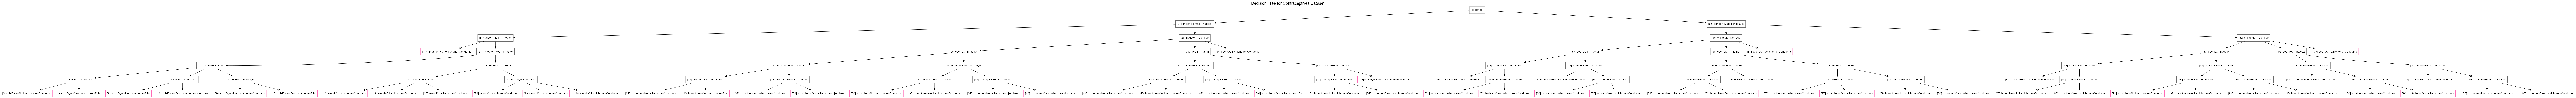

In [25]:
DecisionTree.plurality_value = my_plurality_value
DecisionTree.H = my_H  
DecisionTree.importance = my_importance
DecisionTree.predict = my_predict_dtree  
DecisionTree.accuracy = my_accuracy
DecisionTree.f1_score = my_f1_score
dtree_model = DecisionTree(data_contraceptives)
dtree_model.fit()


img_file = 'results/sexed.png'
img_title = "Decision Tree for Contraceptives Dataset"

# Plot the decision tree
decision_tree = DotExporter(dtree_model.hypothesis, nodeattrfunc=utils.set_terminal, 
                            options=['labelloc="t";','label="{0}";'.format(img_title),
                                     'fontsize="20";', 
                                     'graph [fontname = "helvetica"];',
                                     'node [fontname = "helvetica"];']
                           ).to_picture(img_file)

from IPython.display import Image
Image(img_file)

### Evaluating the performance of the model

<br>

The cell below will be responsible for determining the accuracy of the model as well as generating and plotting the confusion matrix. It does so by doing the following steps:
* use the fitted model to predict the target output of the samples in the test data set
* compare the predicted values with the actual values and generate a confusion matrix
* calculate the accuracy of the model
* plot the confusion matrix

<br>

This is primarily based on the accuracy function in CS 180 ME 2 on Artificial Neural Networks.

<br>

---

! Make sure to first run the cells above before running this.

Test Accuracy: 63.0

F1 Scores
Condoms     :	0.8  
IUDs        :	0.0  
Injectibles :	0.17 
Pills       :	0.08 
Implants    :	0.0  
----------------------
Average F1  :	0.21 


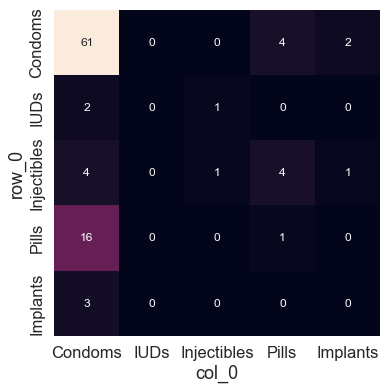

In [26]:
def confusion_matrix(results):   
    fig, ax = plt.subplots(figsize=(16, 6))
    p = sns.heatmap(results, annot=True, ax=ax, cbar=False, 
                    annot_kws={"fontsize":12}, fmt='g')
    ax.set_aspect('equal')
    fig.savefig('results/confusionmatrix.png')
    
samples = data_contraceptives_samp['samples']
val_pred = [dtree_model.predict(samples.iloc[i]) for i in range(len(samples))]
val_true = list(samples['whichone'])

y_m = pd.Categorical(val_true, categories=eng_cont)
y_t = pd.Categorical(val_pred, categories=eng_cont)

results = pd.crosstab(y_m, y_t, dropna=False)
accuracy = np.round(dtree_model.accuracy(results)*100,2)
print("Test Accuracy:", accuracy)
dtree_model.f1_score(results)

confusion_matrix(results)
